In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import scvelo as scv
import scanpy as sc
from skimage.draw import polygon
from shapely.geometry import Polygon
import imageio
import tifffile
from matplotlib import pyplot as plt
from PIL import Image
from scipy.stats import linregress
import os
import pickle
import csv
from shapely.geometry import Point
from scipy.spatial import cKDTree

In [2]:
csv_file_path = 'path/to/file/cell_boundaries.csv.gz'
cell_boundaries_csv = pd.read_csv(csv_file_path)
cell_boundaries_csv['vertex_x_coord'] = cell_boundaries_csv['vertex_x']/0.2125
cell_boundaries_csv['vertex_y_coord'] = cell_boundaries_csv['vertex_y']/0.2125
cell_boundaries_csv['vertex_x_coord'] = np.rint(cell_boundaries_csv['vertex_x_coord']).astype(int) 
cell_boundaries_csv['vertex_y_coord'] = np.rint(cell_boundaries_csv['vertex_y_coord']).astype(int) 

In [3]:
cell_boundaries_csv_grouped = cell_boundaries_csv.groupby('cell_id').agg({
    'vertex_x_coord': list,
    'vertex_y_coord': list
}).reset_index()

In [4]:
def create_polygon(x_coords, y_coords):
    points = list(zip(x_coords, y_coords))
    return Polygon(points)

In [5]:
cell_boundaries_csv_grouped['geometry'] = cell_boundaries_csv_grouped.apply(
    lambda row: create_polygon(row['vertex_x_coord'], row['vertex_y_coord']), 
    axis=1
)
cell_boundaries_csv_grouped['centroid'] = cell_boundaries_csv_grouped['geometry'].apply(lambda geom: geom.centroid)


In [6]:
centroid_dist = round(200/0.2125)
cell_boundaries_csv_grouped['centroid'] = cell_boundaries_csv_grouped['geometry'].apply(lambda geom: geom.centroid)

coords = np.array([(centroid.x, centroid.y) for centroid in cell_boundaries_csv_grouped['centroid']])
cell_ids = cell_boundaries_csv_grouped['cell_id'].values

tree = cKDTree(coords)
candidate_pairs = tree.query_pairs(r=centroid_dist)

In [7]:
close_cells = []
for i, j in candidate_pairs:
    cell1_geom = cell_boundaries_csv_grouped.iloc[i]["geometry"]
    cell2_geom = cell_boundaries_csv_grouped.iloc[j]["geometry"]
    
    min_distance = cell1_geom.distance(cell2_geom)
    centroid_dist = cell1_geom.centroid.distance(cell2_geom.centroid)
    
    close_cells.append((cell_ids[i], cell_ids[j], min_distance, centroid_dist))

In [8]:
close_cells_df = pd.DataFrame(close_cells, columns=['Cell_1_ID', 'Cell_2_ID', 'Min_Distance', 'Centroid_Distance'])

In [9]:
#close_cells_df.to_csv("cell_pairs_distance_200Micron.csv", index=False)

In [6]:
close_cells_df = pd.read_csv("cell_pairs_distance_200Micron.csv")

In [7]:
close_cells_df

,Cell_1_ID,Cell_2_ID,Min_Distance,Centroid_Distance
0,nmnclnon-1,oiofnabp-1,504.004960,575.499795
1,ackeicmo-1,oiohmghg-1,365.000000,431.431541
2,logajmgh-1,lokmienp-1,62.393910,132.641341
3,aknnchfn-1,hijifbpm-1,449.110231,505.079724
4,ddmmffje-1,fgchoimh-1,619.397288,689.250186
...,...,...,...,...
9746853,lojpckfk-1,lpfkpnhb-1,579.907751,654.977322
9746854,dbmmeemb-1,ejpmaiii-1,202.607996,261.171219
9746855,dmbepkbl-1,lpjipdoh-1,793.620186,871.337297
9746856,mgahnbkn-1,mgfngdof-1,576.146683,648.572718


In [8]:
close_cells_df["Sorted_Pair"] = close_cells_df.apply(lambda row: tuple(sorted([row["Cell_1_ID"], row["Cell_2_ID"]])), axis=1)
reversed_df = close_cells_df.rename(columns={"Cell_1_ID": "Cell_2_ID", "Cell_2_ID": "Cell_1_ID"})
close_cells_df = pd.concat([close_cells_df, reversed_df], ignore_index=True).drop_duplicates()


In [9]:
close_cells_df

,Cell_1_ID,Cell_2_ID,Min_Distance,Centroid_Distance,Sorted_Pair
0,nmnclnon-1,oiofnabp-1,504.004960,575.499795,"(nmnclnon-1, oiofnabp-1)"
1,ackeicmo-1,oiohmghg-1,365.000000,431.431541,"(ackeicmo-1, oiohmghg-1)"
2,logajmgh-1,lokmienp-1,62.393910,132.641341,"(logajmgh-1, lokmienp-1)"
3,aknnchfn-1,hijifbpm-1,449.110231,505.079724,"(aknnchfn-1, hijifbpm-1)"
4,ddmmffje-1,fgchoimh-1,619.397288,689.250186,"(ddmmffje-1, fgchoimh-1)"
...,...,...,...,...,...
19493711,lpfkpnhb-1,lojpckfk-1,579.907751,654.977322,"(lojpckfk-1, lpfkpnhb-1)"
19493712,ejpmaiii-1,dbmmeemb-1,202.607996,261.171219,"(dbmmeemb-1, ejpmaiii-1)"
19493713,lpjipdoh-1,dmbepkbl-1,793.620186,871.337297,"(dmbepkbl-1, lpjipdoh-1)"
19493714,mgfngdof-1,mgahnbkn-1,576.146683,648.572718,"(mgahnbkn-1, mgfngdof-1)"


In [10]:
close_cells_df['Centroid_Distance'].max()

940.9999009376546

In [11]:
close_cells_df['Min_Distance'].max()

925.0086486082172

In [12]:
df_total = (
    close_cells_df
    .groupby("Cell_1_ID")
    .size()
    .to_frame(name="density_total")
    .reset_index()
)
df_centroid_400 = (
    close_cells_df
    [close_cells_df["Centroid_Distance"] < 400]
    .groupby("Cell_1_ID")
    .size()
    .to_frame(name="density_centroid_400")
    .reset_index()
)
df_centroid_200 = (
    close_cells_df
    [close_cells_df["Centroid_Distance"] < 200]
    .groupby("Cell_1_ID")
    .size()
    .to_frame(name="density_centroid_200")
    .reset_index()
)
df_dist_500 = (
    close_cells_df
    [close_cells_df["Min_Distance"] < 500]
    .groupby("Cell_1_ID")
    .size()
    .to_frame(name="density_dist_500")
    .reset_index()
)
df_dist_100 = (
    close_cells_df
    [close_cells_df["Min_Distance"] < 100]
    .groupby("Cell_1_ID")
    .size()
    .to_frame(name="density_dist_100")
    .reset_index()
)
final_df = df_total
for df_sub in [df_centroid_400, df_centroid_200, df_dist_500, df_dist_100]:
    final_df = final_df.merge(df_sub, on="Cell_1_ID", how="left")
final_df.fillna(0, inplace=True)
final_df[[
    "density_total", 
    "density_centroid_400", 
    "density_centroid_200",
    "density_dist_500",
    "density_dist_100"
]] = final_df[[
    "density_total", 
    "density_centroid_400", 
    "density_centroid_200",
    "density_dist_500",
    "density_dist_100"
]].astype(int)


In [13]:
final_df

,Cell_1_ID,density_total,density_centroid_400,density_centroid_200,density_dist_500,density_dist_100
0,aaaakhln-1,57,23,14,32,8
1,aaaambch-1,51,21,2,28,0
2,aaabcdpo-1,54,23,12,31,7
3,aaabffoh-1,60,22,13,34,11
4,aaabimdn-1,61,22,16,39,14
...,...,...,...,...,...,...
155203,oipacioa-1,150,34,12,69,7
155204,oipamkob-1,131,43,18,68,11
155205,oipbljpc-1,128,40,21,61,12
155206,oipblkbp-1,24,0,0,3,0


# Check co-neuronal activity

In [14]:
mean_intensities_np = np.load('mean_intensities_0924_SMAD_median_subtracted_first.npy')
max_intensities_np = np.load('max_intensities_0924_SMAD_median_subtracted_first.npy')
cell_ids = np.load("cell_ids_0924_SMAD_median_subtracted_first.npy")
adata_mean_intensities = ad.AnnData(
    X=mean_intensities_np,
    obs=[str(i) for i in range(1, 41)],
    var=cell_ids
)
adata_mean_intensities.var_names = adata_mean_intensities.var[0]
adata_mean_intensities.var.columns = ['cell_id']
adata_mean_intensities.obs.columns = ['time_point']
#filtered_var_names = adata_mean_intensities.var_names.intersection(adata.obs_names)
#adata_mean_intensities = adata_mean_intensities[:, filtered_var_names].copy()
#adata_mean_intensities.var['Cluster'] = adata.obs.loc[adata_mean_intensities.var_names, 'cell_type']
cell_medians = np.median(adata_mean_intensities.X, axis=0)
adata_mean_intensities.var['Median'] = cell_medians

var_sds = np.std(adata_mean_intensities.X, axis=0)
adata_mean_intensities.var['mean_sd'] = var_sds
adata_mean_intensities.var['mean_sd_log'] = np.log1p(var_sds)
adata_mean_intensities.var['mean_sd_log_log'] = np.log1p(np.log1p(var_sds))

data = adata_mean_intensities.X.T
medians = np.median(data, axis=1)
auc_above_median = []
for i in range(data.shape[0]):
    above_median = data[i, :] - medians[i]
    above_median[above_median < 0] = 0
    auc = np.sum(above_median)
    auc_above_median.append(auc)
adata_mean_intensities.var["AUC_above_median"] = auc_above_median
adata_mean_intensities.var["AUC_above_median_log"] = np.log1p(auc_above_median)
adata_mean_intensities.var['AUC_above_median_log_log'] = np.log1p(np.log1p(auc_above_median))

In [15]:
df_gcamp = adata_mean_intensities.var

In [16]:
df_gcamp['SD'] = df_gcamp['mean_sd_log']
df_gcamp['AUC'] = df_gcamp['AUC_above_median_log']

In [17]:
df_gcamp

,cell_id,Median,mean_sd,mean_sd_log,mean_sd_log_log,AUC_above_median,AUC_above_median_log,AUC_above_median_log_log,SD,AUC
aaaakhln-1,aaaakhln-1,1.627660,0.130646,0.122790,0.115816,2.069909,1.121648,0.752193,0.122790,1.121648
aaaambch-1,aaaambch-1,1.112613,0.208707,0.189551,0.173576,3.144144,1.421696,0.884468,0.189551,1.421696
aaabcdpo-1,aaabcdpo-1,2.567961,0.303405,0.264980,0.235057,5.262136,1.834521,1.041873,0.264980,1.834521
aaabffoh-1,aaabffoh-1,1.192641,0.146874,0.137040,0.128428,2.909091,1.363305,0.860061,0.137040,1.363305
aaabimdn-1,aaabimdn-1,1.444099,0.234575,0.210726,0.191221,4.453416,1.696242,0.991859,0.210726,1.696242
...,...,...,...,...,...,...,...,...,...,...
oipacioa-1,oipacioa-1,2.557143,0.357170,0.305402,0.266511,6.377778,1.998472,1.098103,0.305402,1.998472
oipamkob-1,oipamkob-1,1.937500,0.339516,0.292308,0.256430,4.968750,1.786538,1.024800,0.292308,1.786538
oipbljpc-1,oipbljpc-1,2.201613,0.368168,0.313472,0.272674,4.951613,1.783662,1.023767,0.313472,1.783662
oipblkbp-1,oipblkbp-1,4.865096,0.234307,0.210510,0.191042,3.658458,1.538685,0.931646,0.210510,1.538685


In [19]:
df_cells = pd.read_csv("path/to/file/cell_type_final_v5.csv")
merged_df = final_df.merge(df_gcamp, left_on="Cell_1_ID", right_on="cell_id", how="inner")
merged_filtered = merged_df[merged_df["Cell_1_ID"].isin(df_cells["Cell_ID"])]

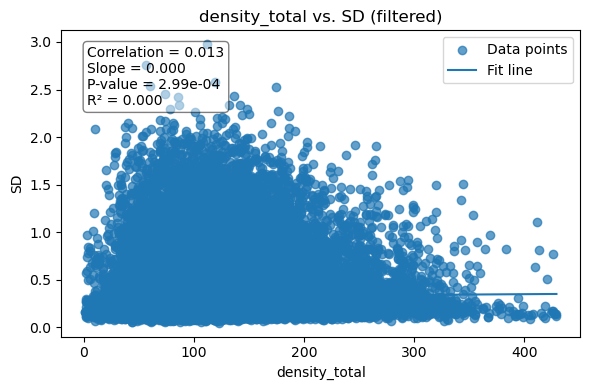

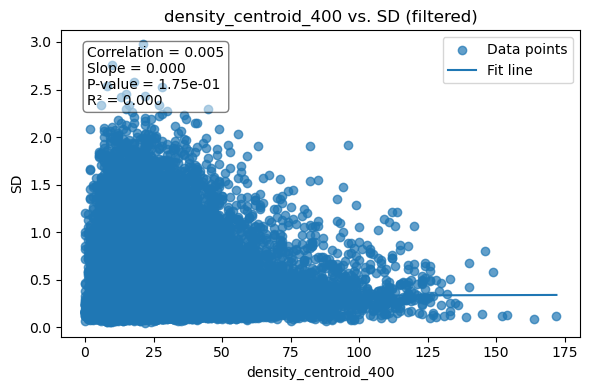

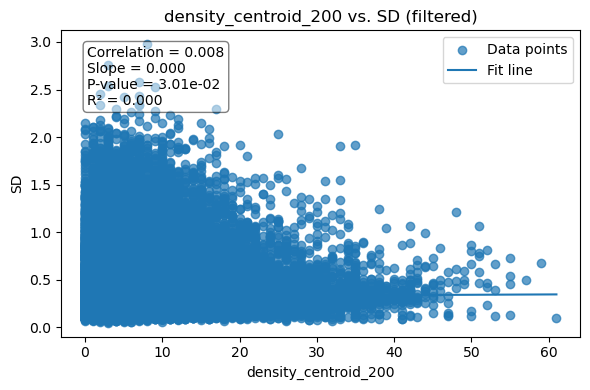

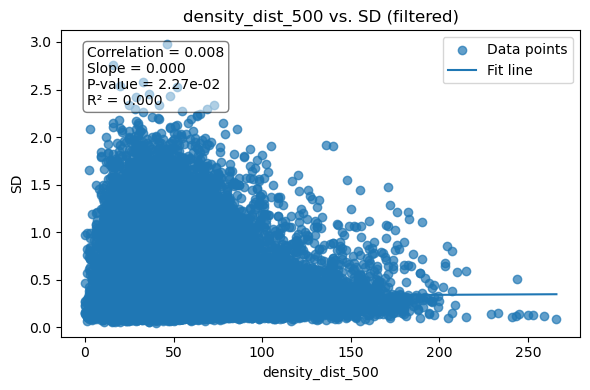

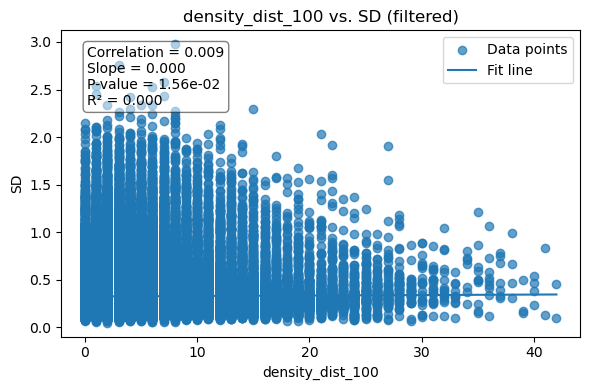

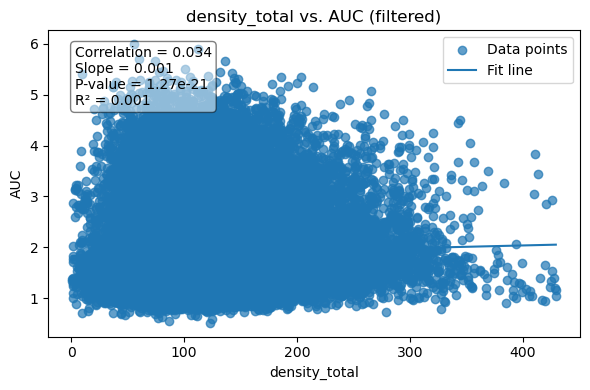

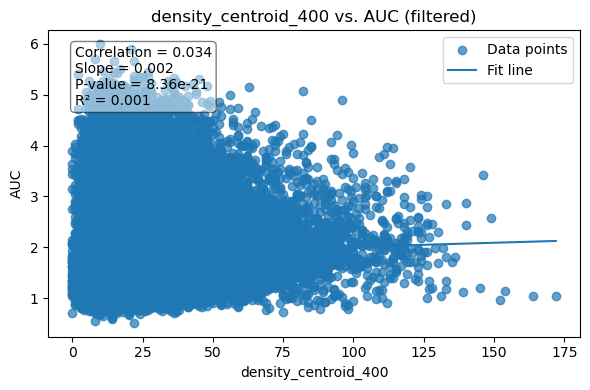

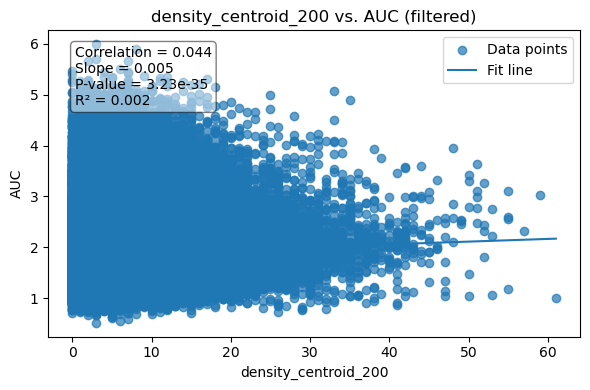

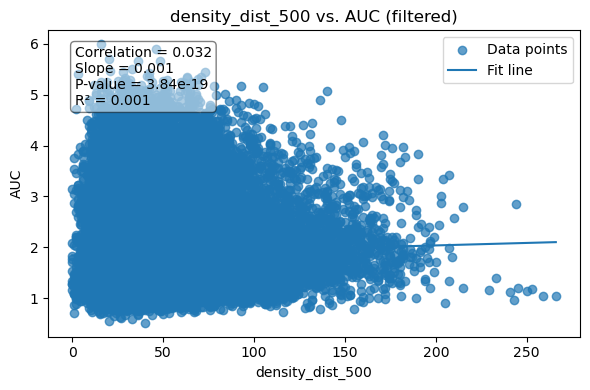

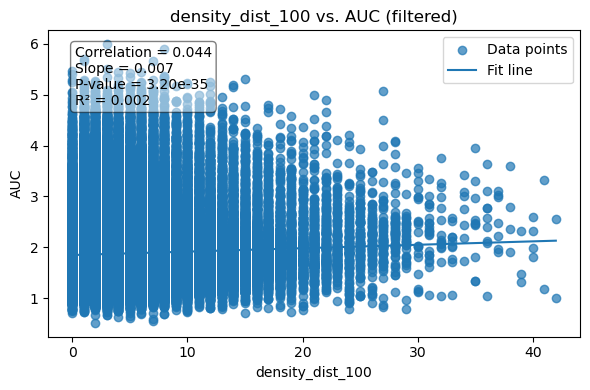

In [20]:
density_cols = [
    "density_total", 
    "density_centroid_400", 
    "density_centroid_200",
    "density_dist_500",
    "density_dist_100"
]
targets = ["SD", "AUC"]

for target in targets:
    for density_col in density_cols:
        x = merged_filtered[density_col].values
        y = merged_filtered[target].values
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        r_squared = r_value**2
        corr = r_value
        plt.figure(figsize=(6,4))
        plt.scatter(x, y, alpha=0.7, label="Data points")

        x_vals = np.array([x.min(), x.max()])
        y_vals = intercept + slope * x_vals
        plt.plot(x_vals, y_vals, label="Fit line")
        plt.text(
            0.05, 0.95,
            f"Correlation = {corr:.3f}\n"
            f"Slope = {slope:.3f}\n"
            f"P-value = {p_value:.2e}\n"
            f"R² = {r_squared:.3f}",
            transform=plt.gca().transAxes,
            verticalalignment="top",
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
        )

        plt.xlabel(density_col)
        plt.ylabel(target)
        plt.title(f"{density_col} vs. {target} (filtered)")
        plt.legend()
        plt.tight_layout()
        plt.show()


# Neighboring Cells Composition

In [23]:
cell_types = pd.read_csv("path/to/file/cell_annotation_final.csv")


In [ ]:
custom_palette = {
    'Excitatory Neurons': '#44a843',   # green
    'Inhibitory Neurons': '#9f78c3',   # lighter purple with a blue tint
    'Neuronal Progenitors': '#9f7269', # medium brown
    'NPC': '#e36d6f',    # pure red (more red)
    'Radial Glia': '#e584c7',          # lighter pink (less red)
    'Cycling Radial Glia': '#ff9c4c',  # orange
    'Astrocytes': '#3985bb',           # medium blue
    'Transitory Neural Cells': '#909394'  # grey
}

In [24]:
close_cells_annot_1 = close_cells_df.merge(
    cell_types.rename(columns={
        "obs_names": "Cell_1_ID",
        "cell_type_final": "cell_type_1"
    }),
    on="Cell_1_ID",
    how="inner"
)

In [25]:
close_cells_annot_2 = close_cells_annot_1.merge(
    cell_types.rename(columns={
        "obs_names": "Cell_2_ID",
        "cell_type_final": "cell_type_2"
    }),
    on="Cell_2_ID", 
    how="inner"
)

In [36]:
close_cells_annot_2_10 = close_cells_annot_2[close_cells_annot_2['Min_Distance']<10]

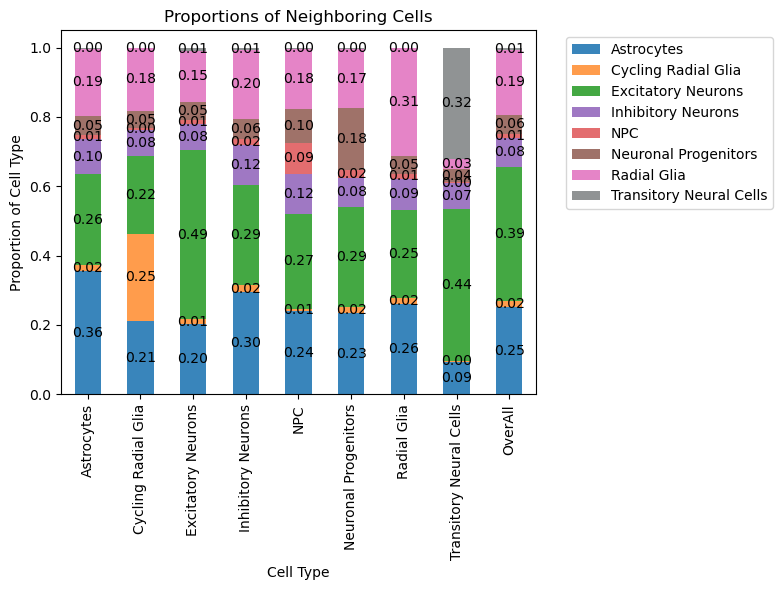

In [37]:
counts_df = (
    close_cells_annot_2
    .groupby(["cell_type_1", "cell_type_2"])
    .size()
    .unstack(fill_value=0)
)
proportions_df = counts_df.div(counts_df.sum(axis=1), axis=0)

unique_cell2 = close_cells_annot_2_velo_10.drop_duplicates(subset="Cell_1_ID")
all_counts_unique = unique_cell2["cell_type_1"].value_counts()
all_proportions = all_counts_unique / all_counts_unique.sum()
proportions_df.loc["OverAll"] = all_proportions.reindex(proportions_df.columns).fillna(0.0)

colors = [custom_palette.get(col, "#333333") for col in proportions_df.columns]
plt.figure(figsize=(8, 6))
ax = proportions_df.plot(kind="bar", stacked=True, ax=plt.gca(), color=colors)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("Proportions of Neighboring Cells")
plt.xlabel("Cell Type")
plt.ylabel("Proportion of Cell Type")
plt.tight_layout()

for i, row_label in enumerate(proportions_df.index):
    cum_height = 0.0
    for col_label in proportions_df.columns:
        val = proportions_df.loc[row_label, col_label]
        if val > 0:
            ax.text(
                i, 
                cum_height + val / 2, 
                f"{val:.2f}",
                ha="center",
                va="center"
            )
        cum_height += val

plt.show()